# Analysis

In [15]:
!pip install librosa --upgrade --quiet

In [16]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
import opendatasets as od
import csv

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import seaborn as sns
import noisereduce as nr
from IPython.display import Audio
import librosa
import librosa.display
import wave

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import prjLib as lib

import warnings
warnings.filterwarnings ('ignore')

In [67]:
# Parameters

FRAME_LEN = 2048 # 4096
HOP_LEN = 512 # 2048
N = 128

FIGX = 14
FIGY = 2

In [17]:
sample_n, sr = librosa.load('ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')
display(sample_n.shape)
Audio(data=sample_n, rate=sr)

(72838,)

In [7]:
sample_f, sr = librosa.load('ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-06-01-01-01-01.wav')
display(sample_f.shape)
Audio(data=sample_f, rate=sr)

(80931,)

In [33]:
def PlotWave(sample,sr,sample_name):
    t = np.linspace(0,sample.size/sr,sample.size)
    plt.plot(t,sample,label=sample_name,alpha=0.75)

def PlotFrames(sample,sample_name,hop_len):
    ft = librosa.frames_to_time(frames=range(len(sample)),hop_length=hop_len)
    plt.plot(ft,sample,label=sample_name,alpha=0.75)

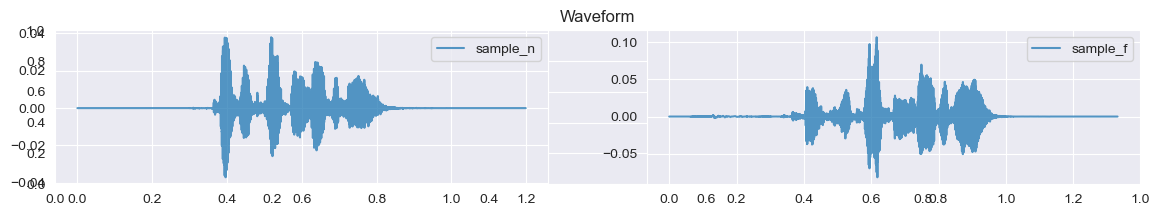

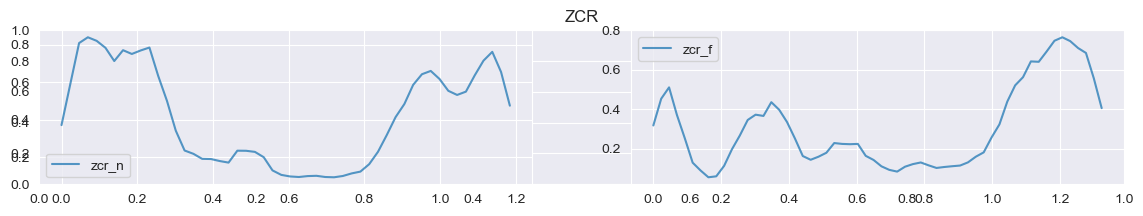

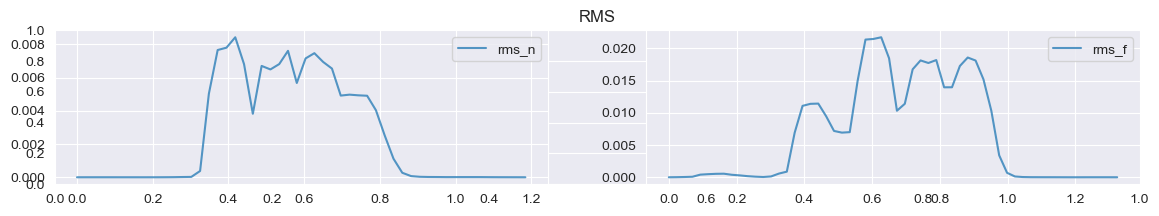

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


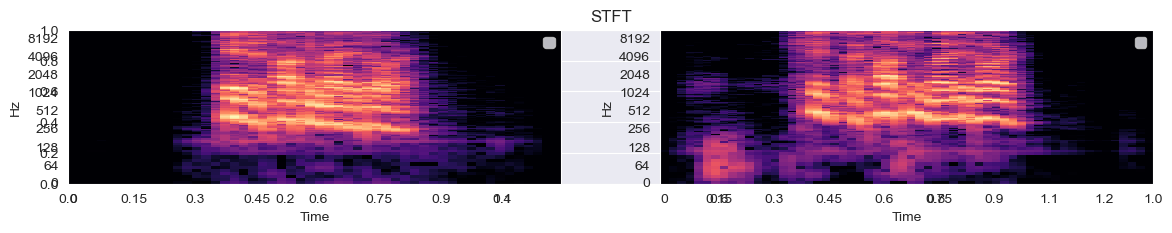

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


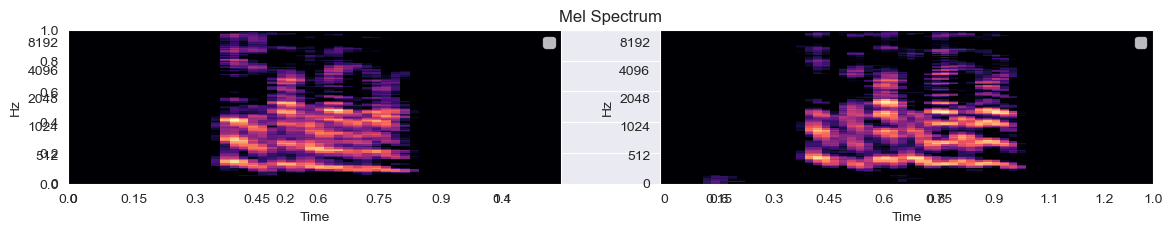

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


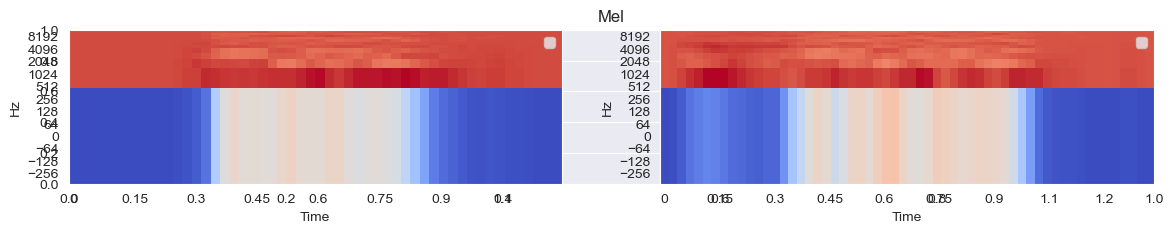

In [75]:
plt.figure(figsize=(FIGX,FIGY))
plt.title('Waveform')
ax = plt.subplot(1,2,1)
sample_n, sr = librosa.load('ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')
sample_n = librosa.resample(sample_n, orig_sr=sr, target_sr=8000)
PlotWave(sample_n,sr,'sample_n')
plt.legend()
ax = plt.subplot(1,2,2)
sample_f, sr = librosa.load('ravdess-emotional-speech-audio/audio_speech_actors_01-24/Actor_01/03-01-06-01-01-01-01.wav')
sample_f = librosa.resample(sample_f, orig_sr=sr, target_sr=8000)
PlotWave(sample_f,sr,'sample_f')
plt.legend()
plt.show()

plt.figure(figsize=(FIGX,FIGY))
plt.title('ZCR')
ax = plt.subplot(1,2,1)
PlotFrames(librosa.feature.zero_crossing_rate(y=sample_n,frame_length=FRAME_LEN,hop_length=HOP_LEN).T,'zcr_n',HOP_LEN)
plt.legend()
ax = plt.subplot(1,2,2)
PlotFrames(librosa.feature.zero_crossing_rate(y=sample_f,frame_length=FRAME_LEN,hop_length=HOP_LEN).T,'zcr_f',HOP_LEN)
plt.legend()
plt.show()

plt.figure(figsize=(FIGX,FIGY))
plt.title('RMS')
ax = plt.subplot(1,2,1)
PlotFrames(librosa.feature.rms(y=sample_n,frame_length=FRAME_LEN,hop_length=HOP_LEN).T,'rms_n',HOP_LEN)
plt.legend()
ax = plt.subplot(1,2,2)
PlotFrames(librosa.feature.rms(y=sample_f,frame_length=FRAME_LEN,hop_length=HOP_LEN).T,'rms_f',HOP_LEN)
plt.legend()
plt.show()

plt.figure(figsize=(FIGX,FIGY))
plt.title('STFT')
ax = plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y=sample_n,n_fft=FRAME_LEN,hop_length=HOP_LEN)),ref=np.max),y_axis='log',x_axis='time',ax=ax)
plt.legend()
ax = plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(y=sample_f,n_fft=FRAME_LEN,hop_length=HOP_LEN)),ref=np.max),y_axis='log',x_axis='time',ax=ax)
plt.legend()
plt.show()

plt.figure(figsize=(FIGX,FIGY))
plt.title('Mel Spectrum')
ax = plt.subplot(1,2,1)
librosa.display.specshow(librosa.amplitude_to_db(librosa.feature.melspectrogram(y=sample_n,n_fft=FRAME_LEN,hop_length=HOP_LEN,n_mels=N),ref=np.max),y_axis='mel',x_axis='time',ax=ax)
plt.legend()
ax = plt.subplot(1,2,2)
librosa.display.specshow(librosa.amplitude_to_db(librosa.feature.melspectrogram(y=sample_f,n_fft=FRAME_LEN,hop_length=HOP_LEN,n_mels=N),ref=np.max),y_axis='mel',x_axis='time',ax=ax)
plt.legend()
plt.show()

plt.figure(figsize=(FIGX,FIGY))
plt.title('Mel')
ax = plt.subplot(1,2,1)
librosa.display.specshow(librosa.feature.mfcc(y=sample_n,sr=sr,n_mfcc=13,n_fft=FRAME_LEN,hop_length=HOP_LEN), y_axis='log', x_axis='time',sr=sr)
plt.legend()
ax = plt.subplot(1,2,2)
librosa.display.specshow(librosa.feature.mfcc(y=sample_f,sr=sr,n_mfcc=13,n_fft=FRAME_LEN,hop_length=HOP_LEN), y_axis='log', x_axis='time',sr=sr)
plt.legend()
plt.show()


In [5]:
# Functions

def FixSamples(sample,sr,max_seconds):
    leng = sr * 2 * max_seconds
    fix_sample = np.zeros([leng,1])
    fix_sample[leng-len(sample):] = sample.reshape(sample.shape[0],1)
    return fix_sample[:,0]

def ExtractLabel(audio_file_path,dataset_name):
    emotion = -1
    gender = 0
    if (dataset_name == 'RAVDESS'):
        emotion = int(audio_file_path[7:8]) - 1
        gender = int(audio_file_path[18:20]) & 0x1
    if (dataset_name == 'TESS'):
        if '_neutral' in audio_file_path:
            emotion = 0
        if '_happy' in audio_file_path:
            emotion = 2
        if '_sad' in audio_file_path:
            emotion = 3
        if '_angry' in audio_file_path:
            emotion = 4
        if '_fear' in audio_file_path:
            emotion = 5
        if '_disgust' in audio_file_path:
            emotion = 6
        if '_ps' in audio_file_path:
            emotion = 7
        if 'OAF_' in audio_file_path:
            gender = 1
        if 'YAF_' in audio_file_path:
            gender = 0
    if (dataset_name == 'CREMA-D'):
        if '_NEU_' in audio_file_path:
            emotion = 0
        if '_HAP_' in audio_file_path:
            emotion = 2
        if '_SAD_' in audio_file_path:
            emotion = 3
        if '_ANG_' in audio_file_path:
            emotion = 4
        if '_FEA_' in audio_file_path:
            emotion = 5
        if '_DIS_' in audio_file_path:
            emotion = 6
        speaker_id = int(audio_file_path[0:4])
        df = pd.read_csv('cremad/VideoDemographics.csv')
        df = df.loc[df['ActorID'] == speaker_id]
        gender = int(df['Sex'] == 'Male')
    if (dataset_name == 'SAVEE'):
        if 'n' in audio_file_path:
            emotion = 0
        if 'h' in audio_file_path:
            emotion = 2
        if 'sa' in audio_file_path:
            emotion = 3
        if 'a' in audio_file_path:
            emotion = 4
        if 'f' in audio_file_path:
            emotion = 5
        if 'd' in audio_file_path:
            emotion = 6
        if 'su' in audio_file_path:
            emotion = 7
        gender = 1
    return np.concatenate(np.array([emotion,gender]).reshape(1,2),axis=0)

'''
def MyZCR(sample,z):
    sample -= z
    zcr = 0
    for ii in range(len(sample)-1):
        if sample[ii]*sample[ii+1] < 0:
            zcr += 1
    return zcr
'''

def extract_mvs(feature,leng,axis):
    Mean = np.mean(feature,axis=axis).reshape(leng,1)
    Var = np.var(feature,axis=axis).reshape(leng,1)
    Sum = np.sum(feature,axis=axis).reshape(leng,1)
    Max = np.max(feature,axis=axis).reshape(leng,1)
    ArgMax = np.argmax(feature,axis=axis).reshape(leng,1)
    MaxMeanRatio = Max / Mean
    ArgMaxArgsRatio = ArgMax / feature.shape[1]
    return [Mean, Var, Sum, MaxMeanRatio, ArgMaxArgsRatio]

def extract_tempogram(sample):
    tempogram = librosa.feature.tempogram(y=sample)
    tempogramMvsT = extract_mvs(tempogram,leng=tempogram.shape[0],axis=1)
    tempogramMvsF = extract_mvs(tempogram,leng=tempogram.shape[1],axis=0)
    tempogram_f = [ tempogram, 
                    tempogramMvsT[0], tempogramMvsT[1], tempogramMvsT[2], tempogramMvsT[3], tempogramMvsT[4],
                    tempogramMvsF[0], tempogramMvsF[1], tempogramMvsF[2], tempogramMvsF[3], tempogramMvsF[4] ]
    return tempogram_f

def extract_fourier_tempogram(sample):
    ftempogram = librosa.feature.fourier_tempogram(y=sample)
    ftempogramMvsT = extract_mvs(ftempogram,leng=ftempogram.shape[0],axis=1)
    ftempogramMvsF = extract_mvs(ftempogram,leng=ftempogram.shape[1],axis=0)
    ftempogram_f = [    ftempogram, 
                        ftempogramMvsT[0], ftempogramMvsT[1], ftempogramMvsT[2], ftempogramMvsT[3], ftempogramMvsT[4],
                        ftempogramMvsF[0], ftempogramMvsF[1], ftempogramMvsF[2], ftempogramMvsF[3], ftempogramMvsF[4] ]
    return ftempogram_f

def extract_tempogram_ratio(sample):
    rtempogram = librosa.feature.tempogram_ratio(y=sample)
    rtempogramMvsT = extract_mvs(rtempogram,leng=rtempogram.shape[0],axis=1)
    rtempogramMvsF = extract_mvs(rtempogram,leng=rtempogram.shape[1],axis=0)
    rtempogram_f = [    rtempogram, 
                        rtempogramMvsT[0], rtempogramMvsT[1], rtempogramMvsT[2], rtempogramMvsT[3], rtempogramMvsT[4],
                        rtempogramMvsF[0], rtempogramMvsF[1], rtempogramMvsF[2], rtempogramMvsF[3], rtempogramMvsF[4] ]
    return rtempogram_f

def extract_zcr(sample):
    zcr = librosa.feature.zero_crossing_rate(y=sample)
    mvs = extract_mvs(zcr,leng=1,axis=1)
    return [zcr, mvs[0], mvs[1], mvs[2], mvs[3], mvs[4]]

def extract_rms(sample,z):
    rms = librosa.feature.rms(y=sample)
    mvs = extract_mvs(rms,leng=1,axis=1)
    # scr = MyZCR(rms,z)
    return [rms, mvs[0], mvs[1], mvs[2], mvs[3], mvs[4]] # , scr

def extract_mfcc(sample,sr,n_mfcc):
    mfcc = librosa.feature.mfcc(y=sample, sr=sr , n_mfcc=n_mfcc)
    mfccMvsT = extract_mvs(mfcc,leng=mfcc.shape[0],axis=1)
    mfccMvsF = extract_mvs(mfcc,leng=mfcc.shape[1],axis=0)
    mfcc_f = [  mfcc, 
                mfccMvsT[0], mfccMvsT[1], mfccMvsT[2], mfccMvsT[3], mfccMvsT[4],
                mfccMvsF[0], mfccMvsF[1], mfccMvsF[2], mfccMvsF[3], mfccMvsF[4] ]
    return mfcc_f

'''
def extract_dmfcc(mfcc):
    dmfcc = librosa.feature.delta(mfcc)
    dmfccMvsT = extract_mvs(dmfcc,leng=dmfcc.shape[0],axis=1)
    dmfccMvsF = extract_mvs(dmfcc,leng=dmfcc.shape[1],axis=0)
    dmfcc_f = [ dmfcc, 
                dmfccMvsT[0], dmfccMvsT[1], dmfccMvsT[2], dmfccMvsT[3], dmfccMvsT[4],
                dmfccMvsF[0], dmfccMvsF[1], dmfccMvsF[2], dmfccMvsF[3], dmfccMvsF[4]    ]
    return dmfcc_f

def extract_ber(mfcc,F):
    ber = np.zeros([1,mfcc.shape[1]])
    for tt in range(mfcc.shape[1]):
        ber[:,tt] = (mfcc[0:F,tt].T @ mfcc[0:F,tt]) / (mfcc[F:,tt].T @ mfcc[F:,tt]) # np.sum(np.square(mfcc[0:F,tt])) / np.sum(np.square(mfcc[F:,tt]))
    berMvsT = extract_mvs(ber,leng=ber.shape[0],axis=1)
    berMvsF = extract_mvs(ber,leng=ber.shape[1],axis=0)
    ber_f = [   ber, 
                berMvsT[0], berMvsT[1], berMvsT[2], berMvsT[3], berMvsT[4],
                berMvsF[0], berMvsF[1], berMvsF[2], berMvsF[3], berMvsF[4]    ]
    return ber_f

def extract_scentoid(mfcc):
    sc = np.zeros([1,mfcc.shape[1]])
    I = np.ones([mfcc.shape[0],1])
    n = np.arange(0,mfcc.shape[0])+1
    for tt in range(mfcc.shape[1]):
        sc[:,tt] = (mfcc[:,tt].T @ n) / (mfcc[:,tt].T @ I)
    scMvsT = extract_mvs(sc,leng=sc.shape[0],axis=1)
    scMvsF = extract_mvs(sc,leng=sc.shape[1],axis=0)
    sc_f = [    sc, 
                scMvsT[0], scMvsT[1], scMvsT[2], scMvsT[3], scMvsT[4],
                scMvsF[0], scMvsF[1], scMvsF[2], scMvsF[3], scMvsF[4]    ]
    return sc_f

def extract_sbandwidth(mfcc,sc):
    bw = np.zeros([1,mfcc.shape[1]])
    I = np.ones([mfcc.shape[0],1])
    n = np.arange(0,mfcc.shape[0])+1
    for tt in range(mfcc.shape[1]):
        var = np.abs(n-sc[tt])
        bw[:,tt] = (mfcc[:,tt].T @ var) / (mfcc[:,tt].T @ I)
    bwMvsT = extract_mvs(bw,leng=bw.shape[0],axis=1)
    bwMvsF = extract_mvs(bw,leng=bw.shape[1],axis=0)
    bw_f = [    bw, 
                bwMvsT[0], bwMvsT[1], bwMvsT[2], bwMvsT[3], bwMvsT[4],
                bwMvsF[0], bwMvsF[1], bwMvsF[2], bwMvsF[3], bwMvsF[4]    ]
    return bw_f
'''

def extract_scentroid(sample):
    sc = librosa.feature.spectral_centroid(y=sample)
    scMvsT = extract_mvs(sc,leng=sc.shape[0],axis=1)
    return [sc, scMvsT[0], scMvsT[1], scMvsT[2], scMvsT[3], scMvsT[4]]

def extract_sbandwidth(sample):
    bw = librosa.feature.spectral_bandwidth(y=sample)
    bwMvsT = extract_mvs(bw,leng=bw.shape[0],axis=1)
    return [bw, bwMvsT[0], bwMvsT[1], bwMvsT[2], bwMvsT[3], bwMvsT[4]]

def extract_spectral_contrast(sample):
    scontrast = librosa.feature.spectral_contrast(y=sample)
    scontrastMvsT = extract_mvs(scontrast,leng=scontrast.shape[0],axis=1)
    scontrastMvsF = extract_mvs(scontrast,leng=scontrast.shape[1],axis=0)
    scontrast_f = [ scontrast, 
                    scontrastMvsT[0], scontrastMvsT[1], scontrastMvsT[2], scontrastMvsT[3], scontrastMvsT[4],
                    scontrastMvsF[0], scontrastMvsF[1], scontrastMvsF[2], scontrastMvsF[3], scontrastMvsF[4] ]
    return scontrast_f

def extract_spectral_flatness(sample):
    sflat = librosa.feature.spectral_flatness(y=sample)
    mvs = extract_mvs(sflat,leng=1,axis=1)
    return [sflat, mvs[0], mvs[1], mvs[2], mvs[3], mvs[4]]

def extract_spectral_rolloff(sample):
    sroll = librosa.feature.spectral_rolloff(y=sample)
    mvs = extract_mvs(sroll,leng=1,axis=1)
    return [sroll, mvs[0], mvs[1], mvs[2], mvs[3], mvs[4]]

def extract_poly_features(sample):
    poly = librosa.feature.poly_features(y=sample)
    polyMvsT = extract_mvs(poly,leng=poly.shape[0],axis=1)
    polyMvsF = extract_mvs(poly,leng=poly.shape[1],axis=0)
    poly_f = [  poly, 
                polyMvsT[0], polyMvsT[1], polyMvsT[2], polyMvsT[3], polyMvsT[4],
                polyMvsF[0], polyMvsF[1], polyMvsF[2], polyMvsF[3], polyMvsF[4] ]
    return poly_f

def extract_tonnetz(sample):
    tonnetz = librosa.feature.tonnetz(y=sample)
    tonnetzMvsT = extract_mvs(tonnetz,leng=tonnetz.shape[0],axis=1)
    tonnetzMvsF = extract_mvs(tonnetz,leng=tonnetz.shape[1],axis=0)
    tonnetz_f = [   tonnetz, 
                    tonnetzMvsT[0], tonnetzMvsT[1], tonnetzMvsT[2], tonnetzMvsT[3], tonnetzMvsT[4],
                    tonnetzMvsF[0], tonnetzMvsF[1], tonnetzMvsF[2], tonnetzMvsF[3], tonnetzMvsF[4] ]
    return tonnetz_f

def ExtractFeatures(sample,sr,frame_len,hop_len,n_mfcc):
    mfcc = librosa.feature.mfcc(y=sample, sr=sr , n_mfcc=n_mfcc, n_fft=frame_len, win_length=frame_len, hop_length=hop_len)
    mfcc_mean = np.mean(mfcc,axis=1).reshape(mfcc.shape[0],1)
    '''
    # tempo_f = librosa.feature.tempo(y=sample).reshape(1,1)
    # # tempogram_f = extract_tempogram(sample)
    # # ftempogram_f = extract_fourier_tempogram(sample)
    # rtempogram_f = extract_tempogram_ratio(sample)
    # zcr_f = extract_zcr(sample)
    # rms_f = extract_rms(sample,z_threshold)
    # mfcc_f = extract_mfcc(sample,sr,n_mfcc)
    # # X dmfcc_f = extract_dmfcc(mfcc_f[0])
    # # X ddmfcc_f = extract_dmfcc(dmfcc_f[0])
    # # X ber_f = extract_ber(mfcc_f[0],F)
    # sc_f = extract_scentroid(sample)
    # bw_f = extract_sbandwidth(sample)
    # scont_f = extract_spectral_contrast(sample)
    # sflat_f = extract_spectral_flatness(sample)
    # sroll_f = extract_spectral_rolloff(sample)
    # poly_f = extract_poly_features(sample)
    # tonnetz_f = extract_tonnetz(sample)
    features = np.concatenate(( # tempo_f,
                                # # tempogram_f[0].T,
                                # # tempogram_f[1], tempogram_f[2], tempogram_f[3], tempogram_f[4], tempogram_f[5],
                                # # tempogram_f[6], tempogram_f[7], tempogram_f[8], tempogram_f[9], tempogram_f[10],
                                # # ftempogram_f[0].T,
                                # # ftempogram_f[1], ftempogram_f[2], ftempogram_f[3], ftempogram_f[4], ftempogram_f[5],
                                # # ftempogram_f[6], ftempogram_f[7], ftempogram_f[8], ftempogram_f[9], ftempogram_f[10],
                                # # rtempogram_f[0].T,
                                # rtempogram_f[1], rtempogram_f[2], rtempogram_f[3], rtempogram_f[4], rtempogram_f[5],
                                # # rtempogram_f[6], rtempogram_f[7], rtempogram_f[8], rtempogram_f[9], rtempogram_f[10],
                                # # zcr_f[0].T, # 69%
                                # zcr_f[1], zcr_f[2], zcr_f[3], zcr_f[4], zcr_f[5], # 60%
                                # # rms_f[0].T, # 72%
                                # rms_f[1], rms_f[2], rms_f[3], rms_f[4], rms_f[5], # 64%
                                # # np.array([rms_f[6]]).reshape(1,1), # 18%
                                # # np.array([1,2,3]).reshape(3,1), mfcc_f[0].reshape(mfcc_f[0].shape[0]*mfcc_f[0].shape[1],1) # 72%
                                # mfcc_f[1], mfcc_f[2], mfcc_f[3], mfcc_f[4], mfcc_f[5], # 75%
                                # # mfcc_f[6], mfcc_f[7], mfcc_f[8], mfcc_f[9], mfcc_f[10], # 72%
                                # # dmfcc_f[0].reshape(dmfcc_f[0].shape[0]*dmfcc_f[0].shape[1],1), # 68%
                                # # dmfcc_f[1], dmfcc_f[2], dmfcc_f[3], dmfcc_f[4], dmfcc_f[5], # Nun
                                # # dmfcc_f[6], dmfcc_f[7], dmfcc_f[8], dmfcc_f[9], dmfcc_f[10], # 61%
                                # # ddmfcc_f[0].reshape(ddmfcc_f[0].shape[0]*ddmfcc_f[0].shape[1],1), # 67%
                                # # ddmfcc_f[1], ddmfcc_f[2], ddmfcc_f[3], ddmfcc_f[4], ddmfcc_f[5], # Nun
                                # # ddmfcc_f[6], ddmfcc_f[7], ddmfcc_f[8], ddmfcc_f[9], ddmfcc_f[10], # 58%
                                # # ber_f[0].T, np.array([1,2,3]).reshape(3,1) # Nun
                                # # ber_f[1], ber_f[2], ber_f[3], ber_f[4], ber_f[5], # Nun
                                # # sc_f[0].T, # 67%
                                # sc_f[1], sc_f[2], sc_f[3], sc_f[4], sc_f[5],# 60%
                                # # bw_f[0].T, # 65%
                                # bw_f[1], bw_f[2], bw_f[3], bw_f[4], bw_f[5], # 57%
                                # scont_f[1], scont_f[2], scont_f[3], scont_f[4], scont_f[5],
                                # # scont_f[6], scont_f[7], scont_f[8], scont_f[9], scont_f[10],
                                # sflat_f[1], sflat_f[2], sflat_f[3], sflat_f[4], sflat_f[5],
                                # sroll_f[1], sroll_f[2], sroll_f[3], sroll_f[4], sroll_f[5],
                                # poly_f[1], poly_f[2], poly_f[3], poly_f[4], poly_f[5],
                                # # poly_f[6], poly_f[7], poly_f[8], poly_f[9], poly_f[10],
                                # tonnetz_f[1], tonnetz_f[2], tonnetz_f[3], tonnetz_f[4], tonnetz_f[5],
                                # # tonnetz_f[6], tonnetz_f[7], tonnetz_f[8], tonnetz_f[9], tonnetz_f[10],
                                ),axis=0)[:,0]
    '''
    # features = np.concatenate(( mfcc_mean[:,0], mfcc_median[:,0] ),axis=0)[:,0]
    return mfcc_mean[:,0] # features

def TestFeaturesInSimpleModel(train_data,train_labels,test_data,test_labels, n_estimators,min_samples_split,random_state, plot=True):
    if plot:
        lib.PlotCorrMap(train_data, train_labels)
        #lib.PlotPairAllFeature(train_data,train_labels,train_data.shape[1])
    report, score, model = lib.TestClassificationModel(train_data,train_labels,test_data,test_labels,3, paramC=1,kernelType='rbf',n_estimators=n_estimators,min_samples_split=min_samples_split,random_state=random_state, plot=plot)
    feature_importance = []
    if plot:
        feature_importance = lib.FeaturesImportance(model,train_data)
    return report, score, feature_importance
